# California House Prices Prediction

**Kaggle Competition**: [California House Prices](https://www.kaggle.com/competitions/california-house-prices/overview)

이 노트북에서는 캘리포니아 주택 가격을 예측하는 머신러닝 모델을 구축합니다.

## 목차
1. 라이브러리 및 데이터 로드
2. 탐색적 데이터 분석 (EDA)
3. 데이터 전처리
4. 특성 엔지니어링
5. 모델 학습 및 평가
6. **AutoGluon 모델링 (NEW)**
7. 앙상블 및 최종 예측
8. 제출 파일 생성

## 1. 라이브러리 및 데이터 로드

In [1]:
# 기본 라이브러리
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# 전처리 및 모델링
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import LabelEncoder, StandardScaler, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 모델
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge, Lasso, ElasticNet
import xgboost as xgb
import lightgbm as lgb

# 시각화 설정
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12

print('Libraries loaded successfully!')

Libraries loaded successfully!


In [2]:
# 데이터 로드
DATA_PATH = 'data/california-house-prices/'

train = pd.read_csv(DATA_PATH + 'train.csv')
test = pd.read_csv(DATA_PATH + 'test.csv')
submission = pd.read_csv(DATA_PATH + 'sample_submission.csv')

print(f'Train shape: {train.shape}')
print(f'Test shape: {test.shape}')
print(f'Submission shape: {submission.shape}')

Train shape: (47439, 41)
Test shape: (31626, 40)
Submission shape: (31626, 2)


In [3]:
# 데이터 미리보기
train.head()

,Id,Address,Sold Price,Summary,Type,Year built,Heating,Cooling,Parking,Lot,...,Parking features,Tax assessed value,Annual tax amount,Listed On,Listed Price,Last Sold On,Last Sold Price,City,Zip,State
0,0,540 Pine Ln,3825000.0,"540 Pine Ln, Los Altos, CA 94022 is a single f...",SingleFamily,1969.0,"Heating - 2+ Zones, Central Forced Air - Gas","Multi-Zone, Central AC, Whole House / Attic Fan","Garage, Garage - Attached, Covered",1.0,...,"Garage, Garage - Attached, Covered",886486.0,12580.0,2019-10-24,4198000.0,NaN,NaN,Los Altos,94022,CA
1,1,1727 W 67th St,505000.0,"HURRY, HURRY.......Great house 3 bed and 2 bat...",SingleFamily,1926.0,Combination,"Wall/Window Unit(s), Evaporative Cooling, See ...","Detached Carport, Garage",4047.0,...,"Detached Carport, Garage",505000.0,6253.0,2019-10-16,525000.0,2019-08-30,328000.0,Los Angeles,90047,CA
2,2,28093 Pine Ave,140000.0,'THE PERFECT CABIN TO FLIP! Strawberry deligh...,SingleFamily,1958.0,Forced air,NaN,0 spaces,9147.0,...,NaN,49627.0,468.0,2019-08-25,180000.0,NaN,NaN,Strawberry,95375,CA
3,3,10750 Braddock Dr,1775000.0,Rare 2-story Gated 5 bedroom Modern Mediterran...,SingleFamily,1947.0,Central,Central Air,"Detached Carport, Driveway, Garage - Two Door",NaN,...,"Detached Carport, Driveway, Garage - Two Door",1775000.0,20787.0,2019-10-24,1895000.0,2016-08-30,1500000.0,Culver City,90230,CA
4,4,7415 O Donovan Rd,1175000.0,Beautiful 200 acre ranch land with several pas...,VacantLand,NaN,NaN,NaN,0 spaces,NaN,...,NaN,NaN,NaN,2019-06-07,1595000.0,2016-06-27,900000.0,Creston,93432,CA


In [4]:
# 컬럼 정보 확인
print('컬럼 목록:')
print(train.columns.tolist())

컬럼 목록:
['Id', 'Address', 'Sold Price', 'Summary', 'Type', 'Year built', 'Heating', 'Cooling', 'Parking', 'Lot', 'Bedrooms', 'Bathrooms', 'Full bathrooms', 'Total interior livable area', 'Total spaces', 'Garage spaces', 'Region', 'Elementary School', 'Elementary School Score', 'Elementary School Distance', 'Middle School', 'Middle School Score', 'Middle School Distance', 'High School', 'High School Score', 'High School Distance', 'Flooring', 'Heating features', 'Cooling features', 'Appliances included', 'Laundry features', 'Parking features', 'Tax assessed value', 'Annual tax amount', 'Listed On', 'Listed Price', 'Last Sold On', 'Last Sold Price', 'City', 'Zip', 'State']


In [5]:
# 데이터 타입 및 결측치 확인
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47439 entries, 0 to 47438
Data columns (total 41 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Id                           47439 non-null  int64  
 1   Address                      47439 non-null  object 
 2   Sold Price                   47439 non-null  float64
 3   Summary                      47085 non-null  object 
 4   Type                         47439 non-null  object 
 5   Year built                   46394 non-null  float64
 6   Heating                      40587 non-null  object 
 7   Cooling                      26745 non-null  object 
 8   Parking                      46065 non-null  object 
 9   Lot                          33258 non-null  float64
 10  Bedrooms                     44567 non-null  object 
 11  Bathrooms                    43974 non-null  float64
 12  Full bathrooms               39574 non-null  float64
 13  Total interior l

## 2. 탐색적 데이터 분석 (EDA)

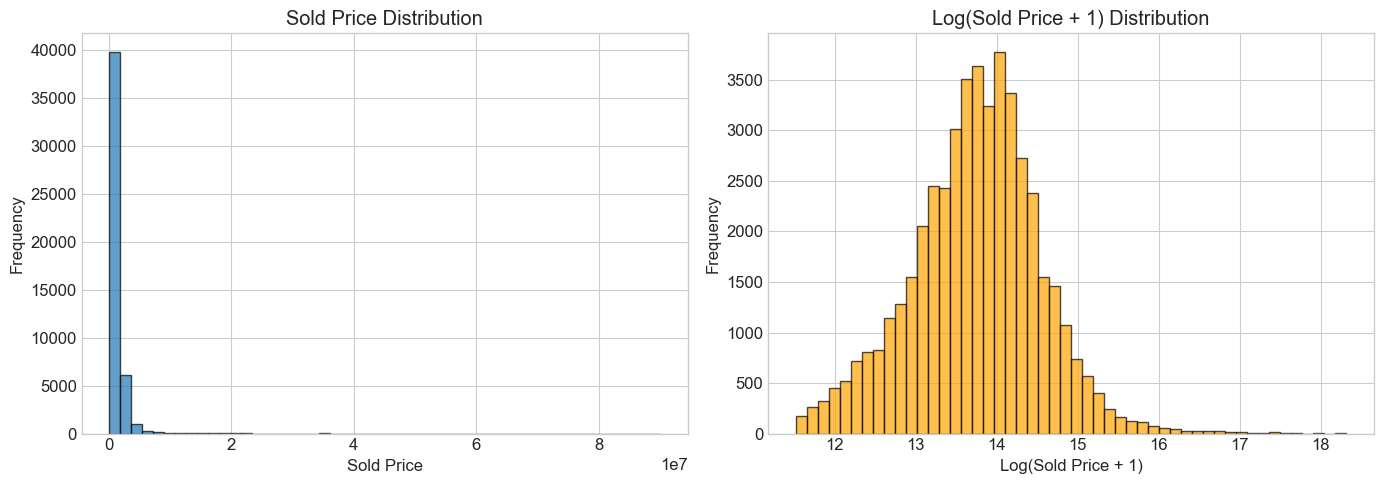

Sold Price 통계:
count    4.743900e+04
mean     1.296050e+06
std      1.694452e+06
min      1.005000e+05
25%      5.650000e+05
50%      9.600000e+05
75%      1.525000e+06
max      9.000000e+07
Name: Sold Price, dtype: float64


In [6]:
# 타겟 변수 분포 확인
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 원본 분포
axes[0].hist(train['Sold Price'], bins=50, edgecolor='black', alpha=0.7)
axes[0].set_title('Sold Price Distribution')
axes[0].set_xlabel('Sold Price')
axes[0].set_ylabel('Frequency')

# 로그 변환 분포
axes[1].hist(np.log1p(train['Sold Price']), bins=50, edgecolor='black', alpha=0.7, color='orange')
axes[1].set_title('Log(Sold Price + 1) Distribution')
axes[1].set_xlabel('Log(Sold Price + 1)')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

print(f"Sold Price 통계:")
print(train['Sold Price'].describe())

In [7]:
# 수치형 변수들의 분포
numeric_cols = train.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols = [col for col in numeric_cols if col not in ['Id', 'Sold Price']]

print(f'수치형 변수: {numeric_cols}')

수치형 변수: ['Year built', 'Lot', 'Bathrooms', 'Full bathrooms', 'Total interior livable area', 'Total spaces', 'Garage spaces', 'Elementary School Score', 'Elementary School Distance', 'Middle School Score', 'Middle School Distance', 'High School Score', 'High School Distance', 'Tax assessed value', 'Annual tax amount', 'Listed Price', 'Last Sold Price', 'Zip']


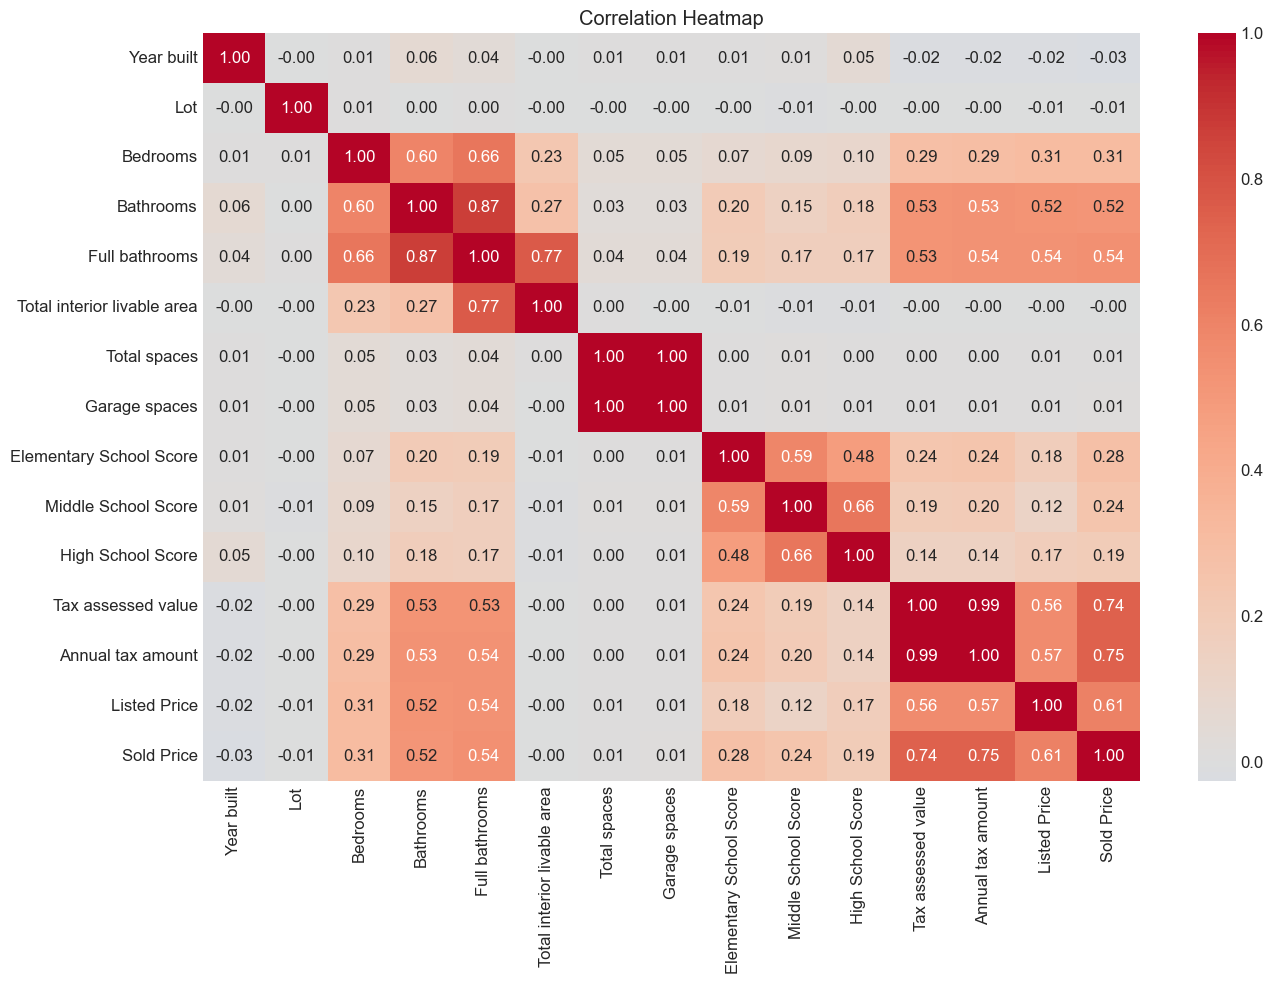

In [8]:
# 주요 수치형 변수와 타겟 간의 상관관계
important_numeric = ['Year built', 'Lot', 'Bedrooms', 'Bathrooms', 'Full bathrooms',
                     'Total interior livable area', 'Total spaces', 'Garage spaces',
                     'Elementary School Score', 'Middle School Score', 'High School Score',
                     'Tax assessed value', 'Annual tax amount', 'Listed Price']

available_cols = [col for col in important_numeric if col in train.columns]

corr_df = train[available_cols + ['Sold Price']].copy()
for col in corr_df.columns:
    corr_df[col] = pd.to_numeric(corr_df[col], errors='coerce')

corr_data = corr_df.corr()

plt.figure(figsize=(14, 10))
sns.heatmap(corr_data, annot=True, fmt='.2f', cmap='coolwarm', center=0)
plt.title('Correlation Heatmap')
plt.tight_layout()
plt.show()

In [9]:
# 타겟과의 상관관계 정렬
target_corr = corr_data['Sold Price'].drop('Sold Price').sort_values(ascending=False)
print('타겟(Sold Price)와의 상관관계:')
print(target_corr)

타겟(Sold Price)와의 상관관계:
Annual tax amount              0.746221
Tax assessed value             0.743233
Listed Price                   0.612651
Full bathrooms                 0.544245
Bathrooms                      0.516208
Bedrooms                       0.306918
Elementary School Score        0.275555
Middle School Score            0.244285
High School Score              0.191616
Garage spaces                  0.009288
Total spaces                   0.007492
Total interior livable area   -0.001520
Lot                           -0.006610
Year built                    -0.027095
Name: Sold Price, dtype: float64


In [10]:
# 결측치 분석
missing = train.isnull().sum()
missing_pct = (missing / len(train) * 100).sort_values(ascending=False)
missing_df = pd.DataFrame({'Missing Count': missing, 'Missing %': missing_pct})
missing_df = missing_df[missing_df['Missing Count'] > 0]

print(f'결측치가 있는 컬럼 수: {len(missing_df)}')
print(missing_df.head(20))

결측치가 있는 컬럼 수: 32
                            Missing Count  Missing %
Annual tax amount                    4310   9.085352
Appliances included                 13593  28.653639
Bathrooms                            3465   7.304117
Bedrooms                             2872   6.054091
Cooling                             20694  43.622336
Cooling features                    22223  46.845423
Elementary School                    4742   9.995995
Elementary School Distance           4742   9.995995
Elementary School Score              4896  10.320622
Flooring                            11569  24.387108
Full bathrooms                       7865  16.579186
Garage spaces                         917   1.933009
Heating                              6852  14.443812
Heating features                     7693  16.216615
High School                          5000  10.539851
High School Distance                 5001  10.541959
High School Score                    5219  11.001497
Last Sold On                 

## 3. 데이터 전처리

In [11]:
# train과 test 데이터 합치기 (전처리 일관성을 위해)
train['is_train'] = 1
test['is_train'] = 0
test['Sold Price'] = np.nan

data = pd.concat([train, test], axis=0, ignore_index=True)
print(f'Combined data shape: {data.shape}')

Combined data shape: (79065, 42)


In [12]:
# 불필요한 컬럼 제거
drop_cols = ['Id', 'Address', 'Summary']  # 텍스트 컬럼 제거
data_id = data['Id'].copy()  # Id 보관

for col in drop_cols:
    if col in data.columns:
        data = data.drop(col, axis=1)

print(f'After dropping columns: {data.shape}')

After dropping columns: (79065, 39)


In [13]:
# 수치형이어야 하는 컬럼들을 강제 변환
numeric_should_be = ['Year built', 'Lot', 'Bedrooms', 'Bathrooms', 'Full bathrooms',
                     'Total interior livable area', 'Total spaces', 'Garage spaces',
                     'Elementary School Score', 'Elementary School Distance',
                     'Middle School Score', 'Middle School Distance',
                     'High School Score', 'High School Distance',
                     'Tax assessed value', 'Annual tax amount', 
                     'Listed Price', 'Last Sold Price']

for col in numeric_should_be:
    if col in data.columns:
        data[col] = pd.to_numeric(data[col], errors='coerce')

# 수치형 / 범주형 컬럼 분리
numeric_features = data.select_dtypes(include=[np.number]).columns.tolist()
numeric_features = [col for col in numeric_features if col not in ['Sold Price', 'is_train']]

categorical_features = data.select_dtypes(include=['object']).columns.tolist()

print(f'수치형 변수 ({len(numeric_features)}개): {numeric_features}')
print(f'\n범주형 변수 ({len(categorical_features)}개): {categorical_features}')

수치형 변수 (19개): ['Year built', 'Lot', 'Bedrooms', 'Bathrooms', 'Full bathrooms', 'Total interior livable area', 'Total spaces', 'Garage spaces', 'Elementary School Score', 'Elementary School Distance', 'Middle School Score', 'Middle School Distance', 'High School Score', 'High School Distance', 'Tax assessed value', 'Annual tax amount', 'Listed Price', 'Last Sold Price', 'Zip']

범주형 변수 (18개): ['Type', 'Heating', 'Cooling', 'Parking', 'Region', 'Elementary School', 'Middle School', 'High School', 'Flooring', 'Heating features', 'Cooling features', 'Appliances included', 'Laundry features', 'Parking features', 'Listed On', 'Last Sold On', 'City', 'State']


In [14]:
# 수치형 변수 결측치 처리 (중앙값으로 대체)
for col in numeric_features:
    if data[col].isnull().sum() > 0:
        median_val = data[col].median()
        data[col] = data[col].fillna(median_val)

print('수치형 변수 결측치 처리 완료')

수치형 변수 결측치 처리 완료


In [15]:
# 범주형 변수 결측치 처리 ('Unknown'으로 대체)
for col in categorical_features:
    if data[col].isnull().sum() > 0:
        data[col] = data[col].fillna('Unknown')

print('범주형 변수 결측치 처리 완료')

범주형 변수 결측치 처리 완료


## 4. 특성 엔지니어링

In [16]:
# 새로운 특성 생성

# 1. 건물 나이
current_year = 2020
data['Building_Age'] = current_year - data['Year built']
data['Building_Age'] = data['Building_Age'].apply(lambda x: max(0, x) if pd.notna(x) else 0)

# 2. 총 욕실 수
data['Total_Bathrooms'] = data['Bathrooms'].fillna(0) + data['Full bathrooms'].fillna(0)

# 3. 침실당 면적
data['Area_per_Bedroom'] = data['Total interior livable area'] / (data['Bedrooms'] + 1)

# 4. 욕실당 면적
data['Area_per_Bathroom'] = data['Total interior livable area'] / (data['Total_Bathrooms'] + 1)

# 5. 주차 공간 비율
data['Garage_Ratio'] = data['Garage spaces'] / (data['Total spaces'] + 1)

# 6. 학교 점수 평균
school_cols = ['Elementary School Score', 'Middle School Score', 'High School Score']
data['Avg_School_Score'] = data[school_cols].mean(axis=1)

# 7. 학교 거리 평균
distance_cols = ['Elementary School Distance', 'Middle School Distance', 'High School Distance']
data['Avg_School_Distance'] = data[distance_cols].mean(axis=1)

# 8. 세금 비율 (세금/평가가)
data['Tax_Rate'] = data['Annual tax amount'] / (data['Tax assessed value'] + 1)

# 9. 리스팅 가격 대비 평가가 비율
data['Price_to_Tax_Ratio'] = data['Listed Price'] / (data['Tax assessed value'] + 1)

# 10. 마지막 판매가 대비 리스팅 가격 비율
data['Price_Appreciation'] = data['Listed Price'] / (data['Last Sold Price'] + 1)

print('특성 엔지니어링 완료')
print(f'새로운 데이터 shape: {data.shape}')

특성 엔지니어링 완료
새로운 데이터 shape: (79065, 49)


In [17]:
# 날짜 특성 추출
date_cols = ['Listed On', 'Last Sold On']

for col in date_cols:
    if col in data.columns:
        data[col] = pd.to_datetime(data[col], errors='coerce')
        data[f'{col}_Year'] = data[col].dt.year
        data[f'{col}_Month'] = data[col].dt.month
        data[f'{col}_Quarter'] = data[col].dt.quarter
        data = data.drop(col, axis=1)

print('날짜 특성 추출 완료')

날짜 특성 추출 완료


In [18]:
# 범주형 변수 인코딩
label_encoders = {}
categorical_features = data.select_dtypes(include=['object']).columns.tolist()

for col in categorical_features:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col].astype(str))
    label_encoders[col] = le

print(f'Label Encoding 완료: {len(categorical_features)}개 컬럼')

Label Encoding 완료: 16개 컬럼


In [19]:
# 무한값 처리
data = data.replace([np.inf, -np.inf], np.nan)

# 새로 생긴 결측치 처리
for col in data.select_dtypes(include=[np.number]).columns:
    if data[col].isnull().sum() > 0:
        data[col] = data[col].fillna(data[col].median())

print('무한값 및 결측치 처리 완료')

무한값 및 결측치 처리 완료


In [20]:
# train/test 분리
train_processed = data[data['is_train'] == 1].drop('is_train', axis=1)
test_processed = data[data['is_train'] == 0].drop(['is_train', 'Sold Price'], axis=1)

# 타겟 변수
y = train_processed['Sold Price']
X = train_processed.drop('Sold Price', axis=1)

# Test 데이터의 Id
test_ids = data_id[data['is_train'] == 0].reset_index(drop=True)

print(f'X shape: {X.shape}')
print(f'y shape: {y.shape}')
print(f'Test shape: {test_processed.shape}')

X shape: (47439, 51)
y shape: (47439,)
Test shape: (31626, 51)


In [21]:
# 타겟 변수 로그 변환 (분포 정규화)
y_log = np.log1p(y)

print(f'Original y - Mean: {y.mean():.2f}, Std: {y.std():.2f}')
print(f'Log y - Mean: {y_log.mean():.2f}, Std: {y_log.std():.2f}')

Original y - Mean: 1296050.50, Std: 1694452.20
Log y - Mean: 13.74, Std: 0.80


## 5. 모델 학습 및 평가

In [22]:
# Train/Validation 분할
X_train, X_val, y_train, y_val = train_test_split(
    X, y_log, test_size=0.2, random_state=42
)

print(f'Train set: {X_train.shape}')
print(f'Validation set: {X_val.shape}')

Train set: (37951, 51)
Validation set: (9488, 51)


In [23]:
# 평가 함수
def evaluate_model(y_true, y_pred, model_name='Model'):
    """모델 평가 지표 계산"""
    # 로그 스케일에서 원래 스케일로 변환
    y_true_orig = np.expm1(y_true)
    y_pred_orig = np.expm1(y_pred)
    
    rmse = np.sqrt(mean_squared_error(y_true_orig, y_pred_orig))
    mae = mean_absolute_error(y_true_orig, y_pred_orig)
    r2 = r2_score(y_true_orig, y_pred_orig)
    
    # RMSLE (Root Mean Squared Log Error) - Kaggle 평가 지표
    rmsle = np.sqrt(mean_squared_error(y_true, y_pred))
    
    print(f'\n{model_name} Performance:')
    print(f'  RMSLE: {rmsle:.4f}')
    print(f'  RMSE: ${rmse:,.0f}')
    print(f'  MAE: ${mae:,.0f}')
    print(f'  R²: {r2:.4f}')
    
    return {'rmsle': rmsle, 'rmse': rmse, 'mae': mae, 'r2': r2}

In [24]:
# 모델 딕셔너리
results = {}

### 5.1 Ridge Regression

In [25]:
# Ridge Regression
ridge = Ridge(alpha=1.0, random_state=42)
ridge.fit(X_train, y_train)

y_pred_ridge = ridge.predict(X_val)
results['Ridge'] = evaluate_model(y_val, y_pred_ridge, 'Ridge Regression')


Ridge Regression Performance:
  RMSLE: 0.5095
  RMSE: $20,409,992
  MAE: $829,865
  R²: -134.6540


### 5.2 Random Forest

In [26]:
# Random Forest
rf = RandomForestRegressor(
    n_estimators=200,
    max_depth=15,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_val)
results['Random Forest'] = evaluate_model(y_val, y_pred_rf, 'Random Forest')


Random Forest Performance:
  RMSLE: 0.2011
  RMSE: $839,905
  MAE: $136,133
  R²: 0.7703


### 5.3 XGBoost

In [27]:
# XGBoost
xgb_model = xgb.XGBRegressor(
    n_estimators=500,
    max_depth=8,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,
    reg_lambda=1,
    random_state=42,
    n_jobs=-1
)
xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=100
)

y_pred_xgb = xgb_model.predict(X_val)
results['XGBoost'] = evaluate_model(y_val, y_pred_xgb, 'XGBoost')

[0]	validation_0-rmse:0.75955
[100]	validation_0-rmse:0.19330
[200]	validation_0-rmse:0.19068
[300]	validation_0-rmse:0.19030
[400]	validation_0-rmse:0.19025
[499]	validation_0-rmse:0.19011

XGBoost Performance:
  RMSLE: 0.1901
  RMSE: $851,228
  MAE: $135,969
  R²: 0.7640


### 5.4 LightGBM

In [28]:
# LightGBM
lgb_model = lgb.LGBMRegressor(
    n_estimators=500,
    max_depth=8,
    learning_rate=0.05,
    num_leaves=50,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,
    reg_lambda=1,
    random_state=42,
    n_jobs=-1,
    verbose=-1
)
lgb_model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)]
)

y_pred_lgb = lgb_model.predict(X_val)
results['LightGBM'] = evaluate_model(y_val, y_pred_lgb, 'LightGBM')


LightGBM Performance:
  RMSLE: 0.1866
  RMSE: $689,303
  MAE: $130,734
  R²: 0.8453


### 5.5 Gradient Boosting

In [29]:
# Gradient Boosting
gb = GradientBoostingRegressor(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    random_state=42
)
gb.fit(X_train, y_train)

y_pred_gb = gb.predict(X_val)
results['Gradient Boosting'] = evaluate_model(y_val, y_pred_gb, 'Gradient Boosting')


Gradient Boosting Performance:
  RMSLE: 0.1889
  RMSE: $702,712
  MAE: $126,736
  R²: 0.8392


In [30]:
# 모델 성능 비교
results_df = pd.DataFrame(results).T
results_df = results_df.sort_values('rmsle')
print('\n===== 모델 성능 비교 (RMSLE 기준) =====')
print(results_df)


===== 모델 성능 비교 (RMSLE 기준) =====
                      rmsle          rmse            mae          r2
LightGBM           0.186638  6.893033e+05  130734.340647    0.845272
Gradient Boosting  0.188897  7.027116e+05  126736.160284    0.839194
XGBoost            0.190109  8.512283e+05  135969.196625    0.764040
Random Forest      0.201123  8.399048e+05  136132.590796    0.770276
Ridge              0.509455  2.040999e+07  829864.802330 -134.653952


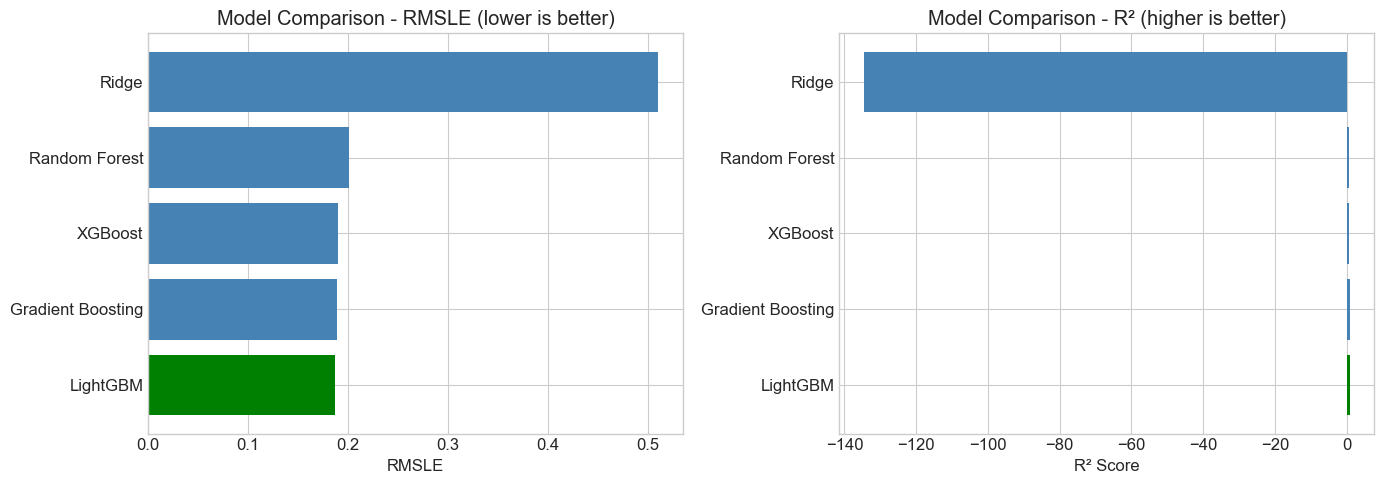

In [31]:
# 모델 성능 시각화
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# RMSLE 비교
colors = ['green' if x == results_df['rmsle'].min() else 'steelblue' for x in results_df['rmsle']]
axes[0].barh(results_df.index, results_df['rmsle'], color=colors)
axes[0].set_xlabel('RMSLE')
axes[0].set_title('Model Comparison - RMSLE (lower is better)')

# R² 비교
colors = ['green' if x == results_df['r2'].max() else 'steelblue' for x in results_df['r2']]
axes[1].barh(results_df.index, results_df['r2'], color=colors)
axes[1].set_xlabel('R² Score')
axes[1].set_title('Model Comparison - R² (higher is better)')

plt.tight_layout()
plt.show()

---

## 6. AutoGluon 모델링 (NEW)

**AutoGluon**은 Amazon에서 개발한 AutoML 라이브러리로, 몇 줄의 코드만으로 최고 성능의 모델을 자동으로 학습합니다.

### AutoGluon의 장점:
- **자동 전처리**: 결측치 처리, 인코딩 등을 자동으로 수행
- **앙상블 학습**: 여러 모델을 자동으로 앙상블
- **하이퍼파라미터 튜닝**: 자동으로 최적의 하이퍼파라미터 탐색
- **다양한 프리셋**: 속도와 성능 사이의 균형 조절 가능

### AutoGluon presets 설명:

| Preset | 설명 | 학습 시간 | 성능 |
|--------|------|----------|------|
| `best_quality` | 최고 성능, 여러 모델 앙상블 | 가장 김 | 최고 |
| `high_quality` | 높은 성능, 적당한 시간 | 김 | 높음 |
| `good_quality` | 적당한 성능 | 중간 | 중간 |
| `medium_quality` | 빠른 학습, 적당한 성능 | 짧음 | 중간 |
| `optimize_for_deployment` | 배포 최적화 | 짧음 | 중간 |

### 6.1 AutoGluon 설치 및 라이브러리 로드

In [32]:
# AutoGluon 설치 (필요시 주석 해제)
# !pip install autogluon

In [33]:
# AutoGluon 라이브러리 로드
from autogluon.tabular import TabularDataset, TabularPredictor

print(f'AutoGluon 라이브러리 로드 완료!')

AutoGluon 라이브러리 로드 완료!


### 6.2 AutoGluon용 데이터 준비

AutoGluon은 전처리를 자동으로 수행하므로, **원본 데이터를 그대로 사용**합니다.
Label Encoding이나 결측치 처리를 별도로 하지 않아도 됩니다.

In [34]:
# AutoGluon용 원본 데이터 다시 로드
train_ag = pd.read_csv(DATA_PATH + 'train.csv')
test_ag = pd.read_csv(DATA_PATH + 'test.csv')

print(f'Train shape: {train_ag.shape}')
print(f'Test shape: {test_ag.shape}')

Train shape: (47439, 41)
Test shape: (31626, 40)


In [35]:
# 불필요한 컬럼 제거 (텍스트 컬럼은 AutoGluon에서 처리하기 어려움)
drop_cols_ag = ['Id', 'Address', 'Summary']

# Test Id 저장
test_ids_ag = test_ag['Id'].copy()

# 컬럼 제거
train_ag = train_ag.drop(columns=drop_cols_ag, errors='ignore')
test_ag = test_ag.drop(columns=drop_cols_ag, errors='ignore')

print(f'After dropping: Train {train_ag.shape}, Test {test_ag.shape}')

After dropping: Train (47439, 38), Test (31626, 37)


In [36]:
# 타겟 변수 로그 변환 (RMSLE 최적화를 위해)
target_col = 'Sold Price'
train_ag[target_col] = np.log1p(train_ag[target_col])

print(f'Target 변수 로그 변환 완료')
print(f'변환 후 평균: {train_ag[target_col].mean():.2f}')

Target 변수 로그 변환 완료
변환 후 평균: 13.74


In [37]:
# Train/Validation 분할
train_ag_data, val_ag_data = train_test_split(
    train_ag, test_size=0.2, random_state=42
)

print(f'AutoGluon Train set: {train_ag_data.shape}')
print(f'AutoGluon Validation set: {val_ag_data.shape}')

AutoGluon Train set: (37951, 38)
AutoGluon Validation set: (9488, 38)


### 현재 내 cpu개수 확인과 모델 돌릴떄 사용할 개수를 지정해줄떄

In [ ]:
import os
os.cpu_count()

In [ ]:
import os
total_cpus = os.cpu_count()
use_cpus = int(total_cpus*(2/3))

In [ ]:
# 모델 학습
predictor_medium.fit(
    num_cpus=use_cpus,
    train_data=train_ag_data,
    tuning_data=val_ag_data,             # 검증 데이터
    presets='medium_quality',            # 프리셋: 중간 품질
    time_limit=300,                      # 최대 5분
    verbosity=2                          # 로그 상세도
)

---

### 6.3 AutoGluon - Medium Quality 모델

**medium_quality** 프리셋은 빠른 학습 속도와 적당한 성능을 제공합니다.

- 학습 시간: 상대적으로 짧음
- 적합한 경우: 빠른 프로토타이핑, 실험, 베이스라인 구축

In [38]:
# AutoGluon Medium Quality 모델 학습
# time_limit: 학습 최대 시간 (초)
# presets: 'medium_quality' - 빠른 학습, 중간 성능

predictor_medium = TabularPredictor(
    label=target_col,                    # 타겟 변수
    problem_type='regression',           # 회귀 문제
    eval_metric='root_mean_squared_error',  # 평가 지표
    path='AutoGluon_medium'              # 모델 저장 경로
)

# 모델 학습
predictor_medium.fit(
    train_data=train_ag_data,
    tuning_data=val_ag_data,             # 검증 데이터
    presets='medium_quality',            # 프리셋: 중간 품질
    time_limit=300,                      # 최대 5분
    verbosity=2                          # 로그 상세도
)

print('\n===== AutoGluon Medium Quality 학습 완료! =====')

Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.5.0
Python Version:     3.11.14
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.26200
CPU Count:          32
Pytorch Version:    2.9.1+cpu
CUDA Version:       CUDA is not available
Memory Avail:       229.86 GB / 255.84 GB (89.8%)
Disk Space Avail:   1694.62 GB / 1906.77 GB (88.9%)
Presets specified: ['medium_quality']
Using hyperparameters preset: hyperparameters='default'
Beginning AutoGluon training ... Time limit = 300s
AutoGluon will save models to "c:\Users\park0\github\sklearn-est15th\AutoGluon_medium"
Train Data Rows:    37951
Train Data Columns: 37
Tuning Data Rows:    9488
Tuning Data Columns: 37
Label Column:       Sold Price
Problem Type:       regression
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    235408.16 MB
	Train Data (Origin


===== AutoGluon Medium Quality 학습 완료! =====


In [39]:
# Medium Quality 모델 리더보드 확인
print('===== AutoGluon Medium Quality - 모델 리더보드 =====')
leaderboard_medium = predictor_medium.leaderboard(val_ag_data, silent=True)
print(leaderboard_medium)

===== AutoGluon Medium Quality - 모델 리더보드 =====
                 model  score_test  score_val              eval_metric  \
0  WeightedEnsemble_L2   -0.185677  -0.185677  root_mean_squared_error   
1             LightGBM   -0.188416  -0.188416  root_mean_squared_error   
2           LightGBMXT   -0.191195  -0.191195  root_mean_squared_error   
3      RandomForestMSE   -0.205301  -0.205301  root_mean_squared_error   

   pred_time_test  pred_time_val     fit_time  pred_time_test_marginal  \
0        1.983418       1.324251  1949.218345                 0.029999   
1        0.593945       0.488878     8.058447                 0.593945   
2        0.593028       0.476368    13.295442                 0.593028   
3        0.766446       0.359006  1927.852231                 0.766446   

   pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  \
0                0.000000           0.012225            2       True   
1                0.488878           8.058447            1       Tru

In [40]:
# Medium Quality 모델 성능 평가
y_pred_ag_medium = predictor_medium.predict(val_ag_data.drop(columns=[target_col]))
y_true_ag = val_ag_data[target_col]

# 로그 스케일에서의 RMSE (= RMSLE)
rmsle_medium = np.sqrt(mean_squared_error(y_true_ag, y_pred_ag_medium))

# 원본 스케일로 변환하여 추가 평가
y_true_orig = np.expm1(y_true_ag)
y_pred_orig = np.expm1(y_pred_ag_medium)

rmse_medium = np.sqrt(mean_squared_error(y_true_orig, y_pred_orig))
mae_medium = mean_absolute_error(y_true_orig, y_pred_orig)
r2_medium = r2_score(y_true_orig, y_pred_orig)

print('\n===== AutoGluon Medium Quality 성능 =====')
print(f'  RMSLE: {rmsle_medium:.4f}')
print(f'  RMSE:  ${rmse_medium:,.0f}')
print(f'  MAE:   ${mae_medium:,.0f}')
print(f'  R²:    {r2_medium:.4f}')

results['AutoGluon (Medium)'] = {
    'rmsle': rmsle_medium, 
    'rmse': rmse_medium, 
    'mae': mae_medium, 
    'r2': r2_medium
}


===== AutoGluon Medium Quality 성능 =====
  RMSLE: 0.1857
  RMSE:  $743,488
  MAE:   $132,186
  R²:    0.8200


In [41]:
# Medium Quality 모델의 Feature Importance
print('\n===== AutoGluon Medium Quality - Feature Importance =====')
importance_medium = predictor_medium.feature_importance(val_ag_data)
print(importance_medium.head(15))

Computing feature importance via permutation shuffling for 37 features using 5000 rows with 5 shuffle sets...



===== AutoGluon Medium Quality - Feature Importance =====


	398.25s	= Expected runtime (79.65s per shuffle set)
	299.59s	= Actual runtime (Completed 5 of 5 shuffle sets)


                             importance    stddev       p_value  n  p99_high  \
Listed Price                   0.686329  0.006924  1.242695e-09  5  0.700585   
Tax assessed value             0.052344  0.001648  1.177242e-07  5  0.055737   
Last Sold Price                0.023301  0.002701  2.128802e-05  5  0.028863   
Listed On                      0.020728  0.002855  4.212839e-05  5  0.026607   
Annual tax amount              0.017100  0.001739  1.267363e-05  5  0.020681   
Total interior livable area    0.004788  0.000947  1.741770e-04  5  0.006737   
Elementary School              0.003975  0.002563  1.281878e-02  5  0.009254   
Zip                            0.003547  0.001242  1.543721e-03  5  0.006105   
High School                    0.002610  0.001080  2.836603e-03  5  0.004833   
Last Sold On                   0.002599  0.000802  9.608808e-04  5  0.004250   
City                           0.001498  0.000311  2.094391e-04  5  0.002138   
Lot                            0.001350 

---

### 6.4 AutoGluon - Best Quality 모델

**best_quality** 프리셋은 최고의 예측 성능을 위해 설계되었습니다.

- 학습 시간: 가장 김 (여러 모델 학습 + 스태킹 앙상블)
- 적합한 경우: 최종 제출, Kaggle 경쟁, 성능이 가장 중요한 경우

**best_quality가 하는 작업:**
1. 다양한 모델 학습 (LightGBM, XGBoost, CatBoost, Neural Network 등)
2. 하이퍼파라미터 튜닝
3. K-Fold Cross Validation으로 Out-of-Fold 예측 생성
4. 스태킹 앙상블 (2단계 모델 학습)

In [ ]:
# AutoGluon Best Quality 모델 학습
# 주의: 학습 시간이 오래 걸릴 수 있습니다!

predictor_best = TabularPredictor(
    label=target_col,
    problem_type='regression',
    eval_metric='root_mean_squared_error',
    path='AutoGluon_best'
)

# 모델 학습
predictor_best.fit(
    train_data=train_ag_data,
    tuning_data=val_ag_data,
    presets='best_quality',              # 프리셋: 최고 품질
    time_limit=600,                      # 최대 10분 (실제 사용시 더 길게 설정 권장)
    verbosity=2
)

print('\n===== AutoGluon Best Quality 학습 완료! =====')

Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.5.0
Python Version:     3.11.14
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.26200
CPU Count:          32
Pytorch Version:    2.9.1+cpu
CUDA Version:       CUDA is not available
Memory Avail:       228.33 GB / 255.84 GB (89.2%)
Disk Space Avail:   1693.51 GB / 1906.77 GB (88.8%)
Presets specified: ['best_quality']
Using hyperparameters preset: hyperparameters='zeroshot'
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
DyStack is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
	This is used to identify the optimal `num_stack_levels` value. Copies of Aut

KeyboardInterrupt: 

In [ ]:
# Best Quality 모델 리더보드 확인
print('===== AutoGluon Best Quality - 모델 리더보드 =====')
leaderboard_best = predictor_best.leaderboard(val_ag_data, silent=True)
print(leaderboard_best)

In [ ]:
# Best Quality 모델 성능 평가
y_pred_ag_best = predictor_best.predict(val_ag_data.drop(columns=[target_col]))

# 로그 스케일에서의 RMSE (= RMSLE)
rmsle_best = np.sqrt(mean_squared_error(y_true_ag, y_pred_ag_best))

# 원본 스케일로 변환
y_pred_best_orig = np.expm1(y_pred_ag_best)

rmse_best = np.sqrt(mean_squared_error(y_true_orig, y_pred_best_orig))
mae_best = mean_absolute_error(y_true_orig, y_pred_best_orig)
r2_best = r2_score(y_true_orig, y_pred_best_orig)

print('\n===== AutoGluon Best Quality 성능 =====')
print(f'  RMSLE: {rmsle_best:.4f}')
print(f'  RMSE:  ${rmse_best:,.0f}')
print(f'  MAE:   ${mae_best:,.0f}')
print(f'  R²:    {r2_best:.4f}')

results['AutoGluon (Best)'] = {
    'rmsle': rmsle_best, 
    'rmse': rmse_best, 
    'mae': mae_best, 
    'r2': r2_best
}

In [ ]:
# Best Quality 모델의 Feature Importance
print('\n===== AutoGluon Best Quality - Feature Importance =====')
importance_best = predictor_best.feature_importance(val_ag_data)
print(importance_best.head(15))

In [ ]:
# Best 모델 상세 정보
print('\n===== AutoGluon Best Quality - 모델 상세 정보 =====')
print(predictor_best.info())

---

### 6.5 AutoGluon 모델 성능 비교

In [ ]:
# AutoGluon 모델 간 성능 비교
print('\n===== AutoGluon Medium vs Best 성능 비교 =====')
print(f'{"Metric":<15} {"Medium Quality":>20} {"Best Quality":>20}')
print('=' * 55)
print(f'{"RMSLE":<15} {rmsle_medium:>20.4f} {rmsle_best:>20.4f}')
print(f'{"RMSE":<15} {f"${rmse_medium:,.0f}":>20} {f"${rmse_best:,.0f}":>20}')
print(f'{"MAE":<15} {f"${mae_medium:,.0f}":>20} {f"${mae_best:,.0f}":>20}')
print(f'{"R²":<15} {r2_medium:>20.4f} {r2_best:>20.4f}')
print('=' * 55)

# 개선율 계산
improvement = ((rmsle_medium - rmsle_best) / rmsle_medium) * 100
print(f'\nBest Quality RMSLE 개선율: {improvement:.2f}%')

In [ ]:
# 시각화: AutoGluon Medium vs Best
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# RMSLE 비교
models_ag = ['Medium Quality', 'Best Quality']
rmsle_values = [rmsle_medium, rmsle_best]
colors = ['orange', 'green']

axes[0].bar(models_ag, rmsle_values, color=colors, edgecolor='black')
axes[0].set_ylabel('RMSLE')
axes[0].set_title('AutoGluon RMSLE Comparison (lower is better)')
for i, v in enumerate(rmsle_values):
    axes[0].text(i, v + 0.002, f'{v:.4f}', ha='center', fontweight='bold')

# R² 비교
r2_values = [r2_medium, r2_best]

axes[1].bar(models_ag, r2_values, color=colors, edgecolor='black')
axes[1].set_ylabel('R² Score')
axes[1].set_title('AutoGluon R² Comparison (higher is better)')
for i, v in enumerate(r2_values):
    axes[1].text(i, v + 0.005, f'{v:.4f}', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

---

### 6.6 전체 모델 성능 비교 (기존 모델 + AutoGluon)

In [ ]:
# 전체 모델 성능 비교
results_df_all = pd.DataFrame(results).T
results_df_all = results_df_all.sort_values('rmsle')

print('\n===== 전체 모델 성능 비교 (RMSLE 기준 정렬) =====')
print(results_df_all)

In [ ]:
# 전체 모델 성능 시각화
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# AutoGluon 모델 강조 색상
def get_color(model_name, metric_values, metric_type='rmsle'):
    if 'AutoGluon' in model_name:
        if 'Best' in model_name:
            return 'darkgreen'
        return 'lightgreen'
    return 'steelblue'

colors_rmsle = [get_color(idx, results_df_all['rmsle']) for idx in results_df_all.index]
colors_r2 = [get_color(idx, results_df_all['r2']) for idx in results_df_all.index]

# RMSLE 비교
axes[0].barh(results_df_all.index, results_df_all['rmsle'], color=colors_rmsle, edgecolor='black')
axes[0].set_xlabel('RMSLE')
axes[0].set_title('All Models - RMSLE Comparison (lower is better)')
axes[0].axvline(x=results_df_all['rmsle'].min(), color='red', linestyle='--', alpha=0.7, label='Best')

# R² 비교
axes[1].barh(results_df_all.index, results_df_all['r2'], color=colors_r2, edgecolor='black')
axes[1].set_xlabel('R² Score')
axes[1].set_title('All Models - R² Comparison (higher is better)')
axes[1].axvline(x=results_df_all['r2'].max(), color='red', linestyle='--', alpha=0.7, label='Best')

plt.tight_layout()
plt.show()

---

### 6.7 AutoGluon으로 테스트 데이터 예측

In [ ]:
# Best Quality 모델로 테스트 데이터 예측
test_predictions_ag_log = predictor_best.predict(test_ag)

# 로그 스케일에서 원래 스케일로 변환
test_predictions_ag = np.expm1(test_predictions_ag_log)

# 음수 값 처리
test_predictions_ag = np.maximum(test_predictions_ag, 0)

print(f'AutoGluon 예측 완료!')
print(f'예측 개수: {len(test_predictions_ag)}')
print(f'예측값 범위: ${test_predictions_ag.min():,.0f} ~ ${test_predictions_ag.max():,.0f}')
print(f'예측값 평균: ${test_predictions_ag.mean():,.0f}')

In [ ]:
# AutoGluon 제출 파일 생성
submission_ag = pd.DataFrame({
    'Id': test_ids_ag.astype(int),
    'Sold Price': test_predictions_ag
})

# 저장
submission_ag.to_csv('submission_autogluon.csv', index=False)

print('AutoGluon 제출 파일 생성 완료!')
print(submission_ag.head(10))

---

## 7. 앙상블 및 최종 예측 (기존 모델)

In [ ]:
# K-Fold Cross Validation으로 최종 모델 학습 (기존 코드)
n_folds = 5
kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)

# OOF predictions
oof_xgb = np.zeros(len(X))
oof_lgb = np.zeros(len(X))

# Test predictions
test_preds_xgb = np.zeros(len(test_processed))
test_preds_lgb = np.zeros(len(test_processed))

for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
    print(f'\n===== Fold {fold + 1}/{n_folds} =====')
    
    X_tr, X_vl = X.iloc[train_idx], X.iloc[val_idx]
    y_tr, y_vl = y_log.iloc[train_idx], y_log.iloc[val_idx]
    
    # XGBoost
    xgb_fold = xgb.XGBRegressor(
        n_estimators=500,
        max_depth=8,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_alpha=0.1,
        reg_lambda=1,
        random_state=42,
        n_jobs=-1
    )
    xgb_fold.fit(X_tr, y_tr, eval_set=[(X_vl, y_vl)], verbose=0)
    oof_xgb[val_idx] = xgb_fold.predict(X_vl)
    test_preds_xgb += xgb_fold.predict(test_processed) / n_folds
    
    # LightGBM
    lgb_fold = lgb.LGBMRegressor(
        n_estimators=500,
        max_depth=8,
        learning_rate=0.05,
        num_leaves=50,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_alpha=0.1,
        reg_lambda=1,
        random_state=42,
        n_jobs=-1,
        verbose=-1
    )
    lgb_fold.fit(X_tr, y_tr, eval_set=[(X_vl, y_vl)])
    oof_lgb[val_idx] = lgb_fold.predict(X_vl)
    test_preds_lgb += lgb_fold.predict(test_processed) / n_folds
    
    # Fold 결과
    xgb_rmsle = np.sqrt(mean_squared_error(y_vl, oof_xgb[val_idx]))
    lgb_rmsle = np.sqrt(mean_squared_error(y_vl, oof_lgb[val_idx]))
    print(f'XGBoost RMSLE: {xgb_rmsle:.4f}')
    print(f'LightGBM RMSLE: {lgb_rmsle:.4f}')

In [ ]:
# OOF 전체 성능
print('\n===== Overall OOF Performance =====')
xgb_oof_rmsle = np.sqrt(mean_squared_error(y_log, oof_xgb))
lgb_oof_rmsle = np.sqrt(mean_squared_error(y_log, oof_lgb))
print(f'XGBoost OOF RMSLE: {xgb_oof_rmsle:.4f}')
print(f'LightGBM OOF RMSLE: {lgb_oof_rmsle:.4f}')

In [ ]:
# 앙상블 (가중 평균)
w_xgb = 1 / xgb_oof_rmsle
w_lgb = 1 / lgb_oof_rmsle
total_w = w_xgb + w_lgb

w_xgb = w_xgb / total_w
w_lgb = w_lgb / total_w

print(f'XGBoost weight: {w_xgb:.4f}')
print(f'LightGBM weight: {w_lgb:.4f}')

# 앙상블 OOF
oof_ensemble = w_xgb * oof_xgb + w_lgb * oof_lgb
ensemble_rmsle = np.sqrt(mean_squared_error(y_log, oof_ensemble))
print(f'\nEnsemble OOF RMSLE: {ensemble_rmsle:.4f}')

In [ ]:
# 최종 예측 (기존 앙상블)
final_predictions_log = w_xgb * test_preds_xgb + w_lgb * test_preds_lgb
final_predictions = np.expm1(final_predictions_log)

# 음수 값 처리
final_predictions = np.maximum(final_predictions, 0)

print(f'Final predictions shape: {final_predictions.shape}')
print(f'Min: ${final_predictions.min():,.0f}')
print(f'Max: ${final_predictions.max():,.0f}')
print(f'Mean: ${final_predictions.mean():,.0f}')

---

## 8. 제출 파일 생성

In [ ]:
# 기존 앙상블 제출 파일 생성
submission_df = pd.DataFrame({
    'Id': test_ids.astype(int),
    'Sold Price': final_predictions
})

# 저장
submission_df.to_csv('submission.csv', index=False)

print('기존 앙상블 제출 파일 생성 완료!')
print(submission_df.head(10))

In [ ]:
# 예측값 분포 비교 시각화
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 기존 앙상블 vs AutoGluon 예측
axes[0].hist(final_predictions, bins=50, alpha=0.5, label='XGB+LGB Ensemble', density=True)
axes[0].hist(test_predictions_ag, bins=50, alpha=0.5, label='AutoGluon Best', density=True)
axes[0].set_xlabel('Sold Price')
axes[0].set_ylabel('Density')
axes[0].set_title('Prediction Distribution Comparison')
axes[0].legend()

# 로그 스케일
axes[1].hist(np.log1p(final_predictions), bins=50, alpha=0.5, label='XGB+LGB Ensemble', density=True)
axes[1].hist(np.log1p(test_predictions_ag), bins=50, alpha=0.5, label='AutoGluon Best', density=True)
axes[1].set_xlabel('Log(Sold Price + 1)')
axes[1].set_ylabel('Density')
axes[1].set_title('Prediction Distribution (Log Scale)')
axes[1].legend()

plt.tight_layout()
plt.show()

---

## Summary

이 노트북에서 수행한 작업:

### 기존 작업
1. **데이터 탐색 (EDA)**: 타겟 변수 분포, 상관관계, 결측치 분석
2. **데이터 전처리**: 결측치 처리, Label Encoding, 무한값 처리
3. **특성 엔지니어링**: Building_Age, Total_Bathrooms, 학교 점수 평균 등
4. **모델 학습**: Ridge, Random Forest, XGBoost, LightGBM, Gradient Boosting
5. **앙상블**: XGBoost + LightGBM 가중 평균 앙상블

### 추가 작업 (AutoGluon)
6. **AutoGluon Medium Quality**: 빠른 학습, 중간 성능
7. **AutoGluon Best Quality**: 최고 성능, 스태킹 앙상블
8. **성능 비교**: 모든 모델의 RMSLE, R² 비교

---

### AutoGluon 사용 팁

1. **전처리 최소화**: AutoGluon은 자동 전처리를 수행하므로, 원본 데이터를 사용하는 것이 좋습니다.
2. **시간 설정**: `time_limit` 파라미터로 학습 시간을 조절합니다. 더 긴 시간 = 더 좋은 성능
3. **프리셋 선택**:
   - 빠른 실험: `medium_quality`
   - 최종 제출: `best_quality`
4. **GPU 활용**: `predictor.fit(..., num_gpus=1)`로 GPU 가속 가능

### 생성된 제출 파일
- `submission.csv`: XGBoost + LightGBM 앙상블
- `submission_autogluon.csv`: AutoGluon Best Quality 모델